<a href="https://colab.research.google.com/github/NikitaMarshchonok/fraud-detection-2025/blob/main/01_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# download librarys

!pip -q uninstall -y pandas


!pip -q install pandas==2.2.2 scikit-learn xgboost imbalanced-learn mlflow shap optuna kaggle --upgrade --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 246.0 MB/s eta 0:00:00


## 1. Load Dataset
Download CSV from Kaggle “Credit Card Fraud 2013” and read it in pandas.  
Credit Card Fraud 2013

In [5]:
import pandas as pd, pathlib

DATA_PATH = pathlib.Path("data/creditcard.csv")
assert DATA_PATH.exists(), "⛔️ creditcard.csv !"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()



Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Quick EDA – Class Distribution


Class
0    284315
1       492
Name: count, dtype: int64


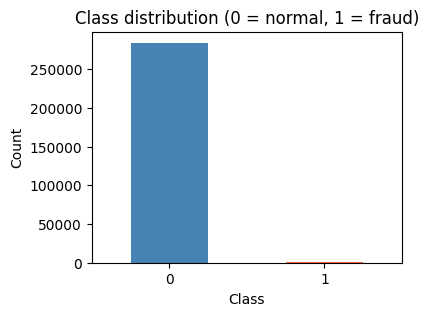

In [6]:
import matplotlib.pyplot as plt

class_counts = df['Class'].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(4,3))
class_counts.plot(kind='bar', color=['steelblue', 'tomato'])
plt.xticks(rotation=0)
plt.title("Class distribution (0 = normal, 1 = fraud)")
plt.ylabel("Count")
plt.show()


## 3. Train–Validation Split (stratified 80/20)


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape},  frauds: {y_train.sum()}")
print(f"Valid shape: {X_valid.shape}, frauds: {y_valid.sum()}")


Train shape: (227845, 30),  frauds: 394
Valid shape: (56962, 30), frauds: 98




***Block C - Baseline model (Logistic Regression) + ROC-AUC and PR-AUC metrics***


## 4. Baseline - Logistic Regression
Use `StandardScaler` for all features and `class_weight="balanced"`.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

baseline_clf = make_pipeline(
    StandardScaler(with_mean=False),     # sparse-friendlier
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced",         # unbalance
        n_jobs=-1,
        solver="lbfgs"
    )
)

baseline_clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

## 5. Metrics (ROC-AUC and PR-AUC) for baseline

In [9]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import numpy as np

y_pred = baseline_clf.predict(X_valid)
y_proba = baseline_clf.predict_proba(X_valid)[:, 1]

print("ROC-AUC :", roc_auc_score(y_valid, y_proba).round(4))
print("PR-AUC  :", average_precision_score(y_valid, y_proba).round(4))
print("\nConfusion matrix:\n", confusion_matrix(y_valid, y_pred))
print("\nClassification report:\n", classification_report(y_valid, y_pred, digits=4))


ROC-AUC : 0.9721
PR-AUC  : 0.7204

Confusion matrix:
 [[55477  1387]
 [    8    90]]

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0609    0.9184    0.1143        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5509     56962
weighted avg     0.9982    0.9755    0.9861     56962



## 6. ROC-curve и Precision-Recall curve


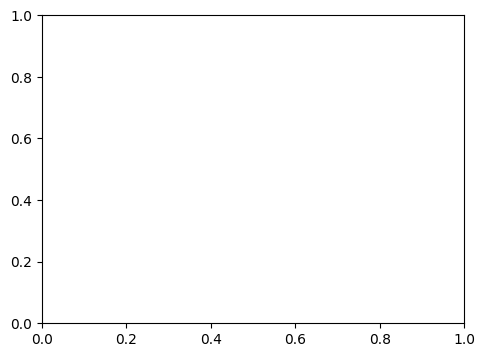

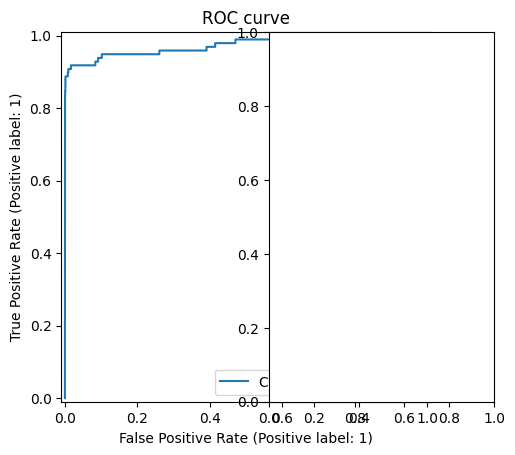

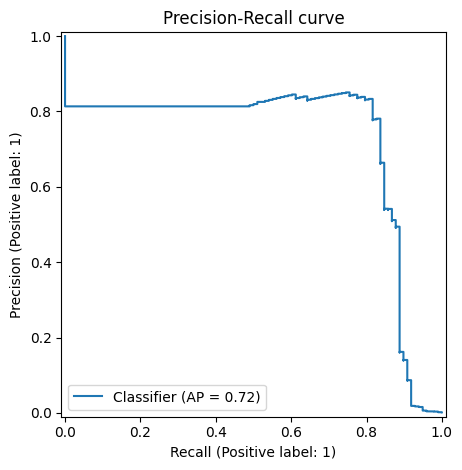

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
RocCurveDisplay.from_predictions(y_valid, y_proba)
plt.title("ROC curve")

plt.subplot(1,2,2)
PrecisionRecallDisplay.from_predictions(y_valid, y_proba)
plt.title("Precision-Recall curve")

plt.tight_layout()
plt.show()


## 7. Improved model — SMOTE + XGBoost


In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline            # from imbalanced-learn
from xgboost import XGBClassifier

smote = SMOTE(random_state=42, sampling_strategy=0.1)   # balanced to 10 : 1

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    n_jobs=-1,
    random_state=42
)

xgb_pipe = Pipeline(steps=[
    ("smote", smote),
    ("xgb",   xgb)
])

xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

## 8.Metrics XGBoost + SMOTE


In [12]:
y_pred_xgb  = xgb_pipe.predict(X_valid)
y_proba_xgb = xgb_pipe.predict_proba(X_valid)[:, 1]

print("ROC-AUC :", roc_auc_score(y_valid, y_proba_xgb).round(4))
print("PR-AUC  :", average_precision_score(y_valid, y_proba_xgb).round(4))
print("\nConfusion matrix:\n", confusion_matrix(y_valid, y_pred_xgb))


ROC-AUC : 0.983
PR-AUC  : 0.8663

Confusion matrix:
 [[56830    34]
 [   13    85]]


## 9. Comparison of ROC / PR-curves (baseline vs XGB)

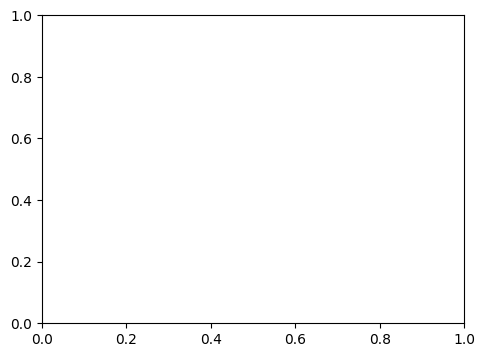

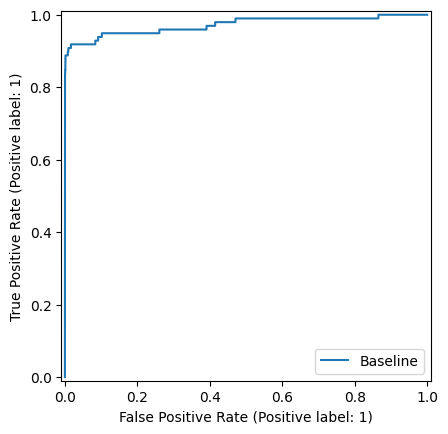

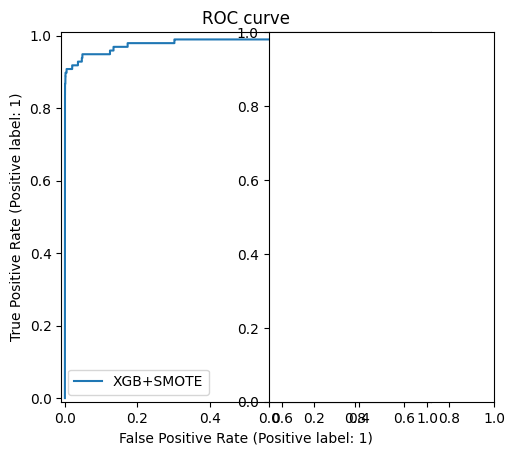

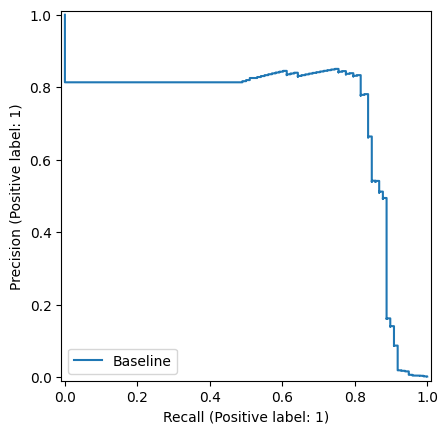

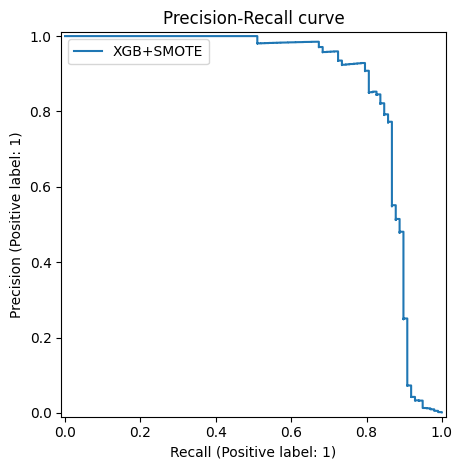

In [13]:
plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
RocCurveDisplay.from_predictions(y_valid, y_proba,  label="Baseline")
RocCurveDisplay.from_predictions(y_valid, y_proba_xgb, label="XGB+SMOTE")
plt.title("ROC curve")
plt.legend()

# PR
plt.subplot(1,2,2)
PrecisionRecallDisplay.from_predictions(y_valid, y_proba,     label="Baseline")
PrecisionRecallDisplay.from_predictions(y_valid, y_proba_xgb, label="XGB+SMOTE")
plt.title("Precision-Recall curve")
plt.legend()

plt.tight_layout(); plt.show()


## 10. Feature importance (XGBoost)


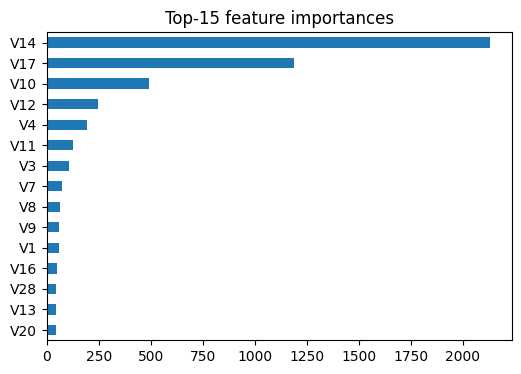

In [14]:
importances = xgb_pipe.named_steps['xgb'].get_booster().get_score(importance_type='gain')
imp_series = pd.Series(importances).sort_values(ascending=False)[:15]
imp_series.plot(kind='barh', figsize=(6,4)); plt.gca().invert_yaxis()
plt.title("Top-15 feature importances"); plt.show()


## 11. Save trained pipeline


In [15]:
import joblib, pathlib
pathlib.Path("src").mkdir(exist_ok=True)
joblib.dump(xgb_pipe, "src/model_xgb.pkl")


['src/model_xgb.pkl']





## 12. Init MLflow




In [16]:
import mlflow
mlflow.set_tracking_uri("file:///content/mlruns")  # locak store
mlflow.set_experiment("credit-card-fraud")

RUN_PARAMS = {
    "model": "XGBClassifier",
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 4,
    "sampling_strategy": 0.1,
}


2025/06/14 10:20:16 INFO mlflow.tracking.fluent: Experiment with name 'credit-card-fraud' does not exist. Creating a new experiment.




## 13. Log run


In [17]:
with mlflow.start_run(run_name="xgb_smote_v1"):
    # parametrs
    mlflow.log_params(RUN_PARAMS)

    # metrics
    mlflow.log_metrics({
        "roc_auc":  roc_auc_score(y_valid, y_proba_xgb),
        "pr_auc":   average_precision_score(y_valid, y_proba_xgb),
        "f1_valid": classification_report(y_valid, y_pred_xgb, output_dict=True)["1"]["f1-score"],
    })

    # pipeline-model
    mlflow.sklearn.log_model(xgb_pipe, artifact_path="model")

    run_id = mlflow.active_run().info.run_id
    print("✅ Logged run_id:", run_id)


2025/06/14 10:20:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/14 10:21:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged run_id: 0c092bf372a747219825308913551261




## 14. MLflow UI (optional)



In [18]:
# lets start MLflow UI (Ctrl-Click in link)
import subprocess, os, threading, time, webbrowser
def run_mlflow_ui():
    os.system("mlflow ui --port 6006 --backend-store-uri file:///content/mlruns")
threading.Thread(target=run_mlflow_ui).start()
time.sleep(3)
print("MLflow UI → http://127.0.0.1:6006")


MLflow UI → http://127.0.0.1:6006
